# #8 : Bayes Statistical Inference using MCMC and JAGS

In [1]:
library(rjags)
library(runjags)
library(optimx)
library(tidyverse)
library(ggplot2)

Warning message:
"package 'rjags' was built under R version 3.6.3"
Loading required package: coda

Warning message:
"package 'coda' was built under R version 3.6.3"
Linked to JAGS 4.3.0

Loaded modules: basemod,bugs

Warning message:
"package 'runjags' was built under R version 3.6.3"
Warning message:
"package 'optimx' was built under R version 3.6.3"
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --

√ ggplot2 3.1.1       √ purrr   0.3.4  
√ tibble  2.1.1       √ dplyr   0.8.0.1
√ tidyr   0.8.3       √ stringr 1.4.0  
√ readr   1.3.1       √ forcats 0.4.0  

Warning message:
"package 'purrr' was built under R version 3.6.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x tidyr::extract()

## Part 1. Hardy-Weinberg Model (Metropolis Algorithm)

#### Hardy-Weinberg Model 
$H_0 : (n_0, n_1, n_2, n_3)$ ~ $Multinomial_4(n, p_0, p_1, p_2, p_3)$       
$p_0 = (\theta_0)^2, p_1 = (\theta_1)^2+2\theta_1\theta_0, p_2 = (\theta_2)^2+2\theta_2\theta_0, p_3 = 2\theta_1\theta_2$         
$\theta_0 = 1-\theta_1-\theta_2$         
    $L(\theta_1, \theta_2) = \prod [p_i(\theta)^{n_i}],     \theta_1 \geq 0, \theta_2 \geq 0, \theta_1+\theta_2 \leq 1$

In [2]:
blood <- data.frame(type = c("O", "A", "B", "AB"), n=c(176,182,60,17))
blood

type,n
<fct>,<dbl>
O,176
A,182
B,60
AB,17


### (a) Metropolis Algorithm 

#### Metropolis Algorithm 
1. 초기값 $\theta_1$을 설정한다. 
2. 서로 독립인 random numbers $(u_1, z_{11}, z_{12})$, $u_1$ ~ $U(0,1)$, $z_{11}$ ~ $N(0,1)$, $z_{12}$ ~ $N(0,1)$를 생성한다. 
3. $\theta^*_{(1)} = \theta_{(1)} + s(z_{11}, z_{12})$를 계산한다.
4. $a_1 = min(1, [L(\theta^*_{(1)}) h(\theta^*_{(1)})] / [L(\theta_{(1)}) h(\theta_{(1)})])$ 를 계산한다. 
5. $\theta_{(2)}$ = $\theta_{(1)}$ if $u_1 > a_1$, else $\theta^*_{(1)}$ 를 계산한다.     
6. 위 과정을 $M-1$번 반복하여 $\theta_{(1)}, ... , \theta_{(M)}$ 를 생성한다. 

In [3]:
flik <- function(theta) {
  theta0 = 1 - theta[1] - theta[2] ; theta1 = theta[1] ; theta2 = theta[2]
  p <- c(theta0^2, theta1^2 + 2*theta1*theta0, theta2^2 + 2*theta2*theta0, 2*theta1*theta2)
  L <- prod(p^blood$n) 
  return(L) 
}

floglik <- function(theta) {
  theta0 = 1 - theta[1] - theta[2] ; theta1 = theta[1] ; theta2 = theta[2]
  p <- c(p0 = theta0^2, p1 = theta1^2 + 2*theta1*theta0, p2 = theta2^2 + 2*theta2*theta0, p3 = 2*theta1*theta2)
  l <- sum(blood$n*log(p)) 
  return(l) 
}

In [4]:
result <- optim(par=c(0.1,0.1), floglik, hessian=T, control = list(fnscale = -1))
result <- optim(par = result$par, floglik, hessian = T, control = list(fnscale = -1))
result

-3900.984,-1067.928
-1067.928,-10057.434


In [5]:
# set initial value : MLE 
theta_mle <- result$par
initial <- theta_mle
initial

[1] 0.26444731 0.09318529

In [6]:
# generate random numbers
set.seed(1234)
M<-1000
u1<-runif(M) 
z1<-rnorm(M)
z2<-rnorm(M)

* prior density : $h(\theta_1, \theta_2) = 2I_A(\theta_1, \theta_2)$
* proposal density : $f(\theta^* | \theta)$ ~ $N_2(\theta, sI_2)$, $s = 1/\sqrt{n}$
* $h(\theta_1, \theta_2 | Data) \propto L(\theta_1, \theta_2) \cdot h(\theta_1, \theta_2)$

In [7]:
# prior
fprior<-function(tt) {
  if (tt[1]>=0 && tt[2]>=0 && tt[1]+tt[2]<=1) {
    h<-2
  } else {
      h<-0}
  return(h)
}

In [8]:
n<-435
s<-1/sqrt(n)
theta<-matrix(NA,ncol=2,nrow=M)
theta_star<-matrix(NA,ncol=2,nrow=M)
a<-c()
theta[1,]<-initial

In [9]:
# generate MCMC dataframe
for (i in 1:(M-1)) {
  theta_star[i,]<-c(theta[i,1]+s*z1[i],theta[i,2]+s*z2[i])
  a[i]<-min(1,((flik(theta_star[i,]))*fprior(theta_star[i,]))/((flik(theta[i,]))*fprior(theta[i,])))
  theta[(i+1),]<-c(ifelse(u1[i]>a[i],theta[i,1],theta_star[i,1]),ifelse(u1[i]>a[i],theta[i,2],theta_star[i,2]))
}

mcmcdf <- data.frame(theta1 = c(theta[,1]), theta2 = c(theta[,2]))

In [10]:
tail(mcmcdf)

,theta1,theta2
,<dbl>,<dbl>
995,0.2740283,0.0923654
996,0.2740283,0.0923654
997,0.2740283,0.0923654
998,0.2740283,0.0923654
999,0.2740283,0.0923654
1000,0.2740283,0.0923654


In [11]:
postinfo <- data.frame(theta1 = c(mean = mean(mcmcdf$theta1), sd = sd(mcmcdf$theta1), quantile(mcmcdf$theta1, c(0.025, 0.25, 0.5, 0.75, 0.975))), theta2 = c(mean = mean(mcmcdf$theta2), sd = sd(mcmcdf$theta2), quantile(mcmcdf$theta2, c(0.025, 0.25, 0.5, 0.75, 0.975))))
postinfo <- as.data.frame(t(postinfo)) ; round(postinfo, 4)

,mean,sd,2.5%,25%,50%,75%,97.5%
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
theta1,0.2660,0.0140,0.2373,0.2573,0.2658,0.2764,0.2938
theta2,0.0943,0.0096,0.0762,0.0885,0.0942,0.1002,0.1129


### (b) Bayes CI vs MLE CI

In [12]:
# Bayes CI 
ci.bayes <- data.frame(mean = c(mean(mcmcdf$theta1), mean(mcmcdf$theta2)), lower = c(sort(mcmcdf$theta1)[25], sort(mcmcdf$theta2)[25]), upper = c(sort(mcmcdf$theta1)[975], sort(mcmcdf$theta2)[975]), row.names = c("theta1", "theta2"))
ci.bayes

,mean,lower,upper
,<dbl>,<dbl>,<dbl>
theta1,0.26597570,0.23729009,0.2937958
theta2,0.09430545,0.07623535,0.1128828


In [13]:
# MLE CI 
J <- -result$hessian
V <- solve(J)
se <- sqrt(diag(V))
ci.fisher <- data.frame(theta_mle, lower = c(theta_mle[1] - 1.96*se[1], theta_mle[2] - 1.96*se[2]), upper = c(theta_mle[1] + 1.96*se[1], theta_mle[2] + 1.96*se[2]), row.names = c("theta1", "theta2")) 
ci.fisher

,theta_mle,lower,upper
,<dbl>,<dbl>,<dbl>
theta1,0.26444731,0.23259985,0.2962948
theta2,0.09318529,0.07335093,0.1130196


* 두 값 간에 차이가 거의 없다. = n이 커지면 MLE와 Bayes 추정량은 거의 동일하다. 
* Fisher Information을 이용하면 분포에 대한 가정 없이, 출력되는 hessian을 이용하면 되므로 편리하다.
* MCMC의 경우는 prior 분포에 따른 sample의 값이 바뀌면 신뢰구간이 바뀌어 버린다는 단점이 있다. 

### (c) 대표본에서의 Laplace Approximation

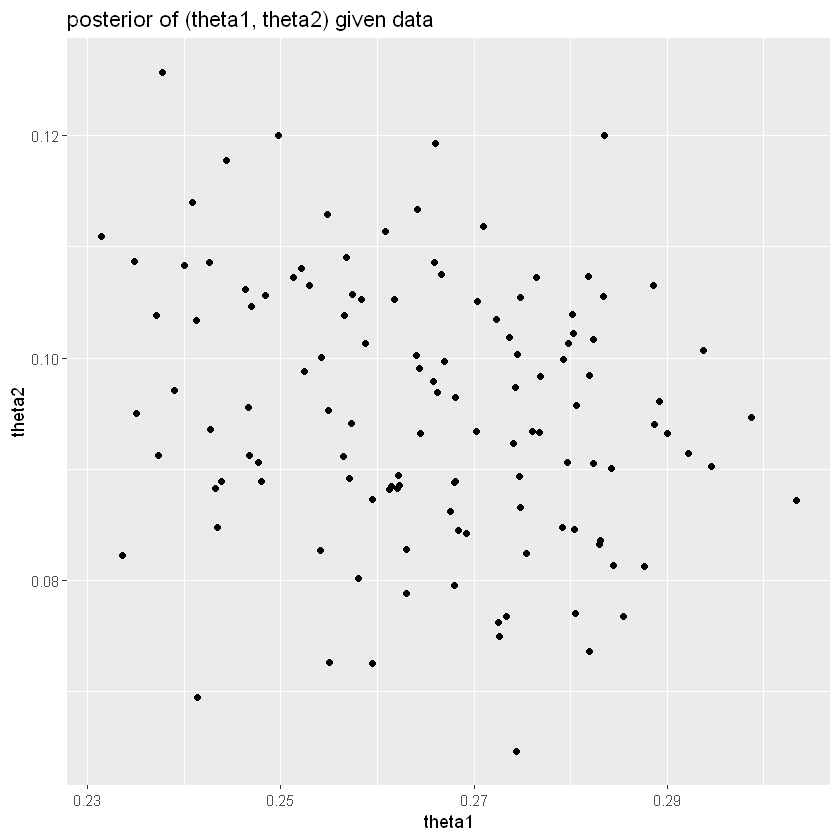

In [14]:
# MCMC of scatter plot 
ggplot(data = mcmcdf) + geom_point(aes(theta1, theta2)) + ggtitle("posterior of (theta1, theta2) given data")

In [22]:
postmean <- postinfo$mean
postcov <- matrix(c(var(mcmcdf$theta1), rep(cov(mcmcdf$theta1, mcmcdf$theta2),2), var(mcmcdf$theta2)), ncol = 2)

data.frame(postmean, theta_mle, row.names = c("theta1", "theta2"))

,postmean,theta_mle
,<dbl>,<dbl>
theta1,0.26597570,0.26444731
theta2,0.09430545,0.09318529


In [23]:
postcov

0.0001961391,-2.545990e-05
-0.0000254599,9.177936e-05


In [24]:
solve(J)

2.640203e-04,-2.803446e-05
-2.803446e-05,1.024057e-04


* hessian의 역행렬과 추정된 MCMC theta들의 분산공분산 행렬은 매우 비슷한 값을 갖는다.

## Part 2. Poisson Change Point Problem

#### Poisson 모형 
* $y_i$ ~ $Poisson(\mu_t)$
* $\mu_t= exp(a - b \cdot H(t-c)) $ 
* t = 1851, ... , 1962



* a, b $\in R$, 1851 $\leq c \leq$ 1962
* $H(x) = I(x \geq 0), x \in R$ 


* c : 평균사고빈도가 $\lambda_1 = e^a$ 에서 $\lambda_2 = e^{a-b}$ 로 변화가 일어난 미지의 변화시점 (change point)를 나타내는 정수 값을 취하는 (integer-valued) 모수 

In [26]:
library(repr)
options(repr.plot.width=15, repr.plot.height=15)

Warning message:
"package 'repr' was built under R version 3.6.3"


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



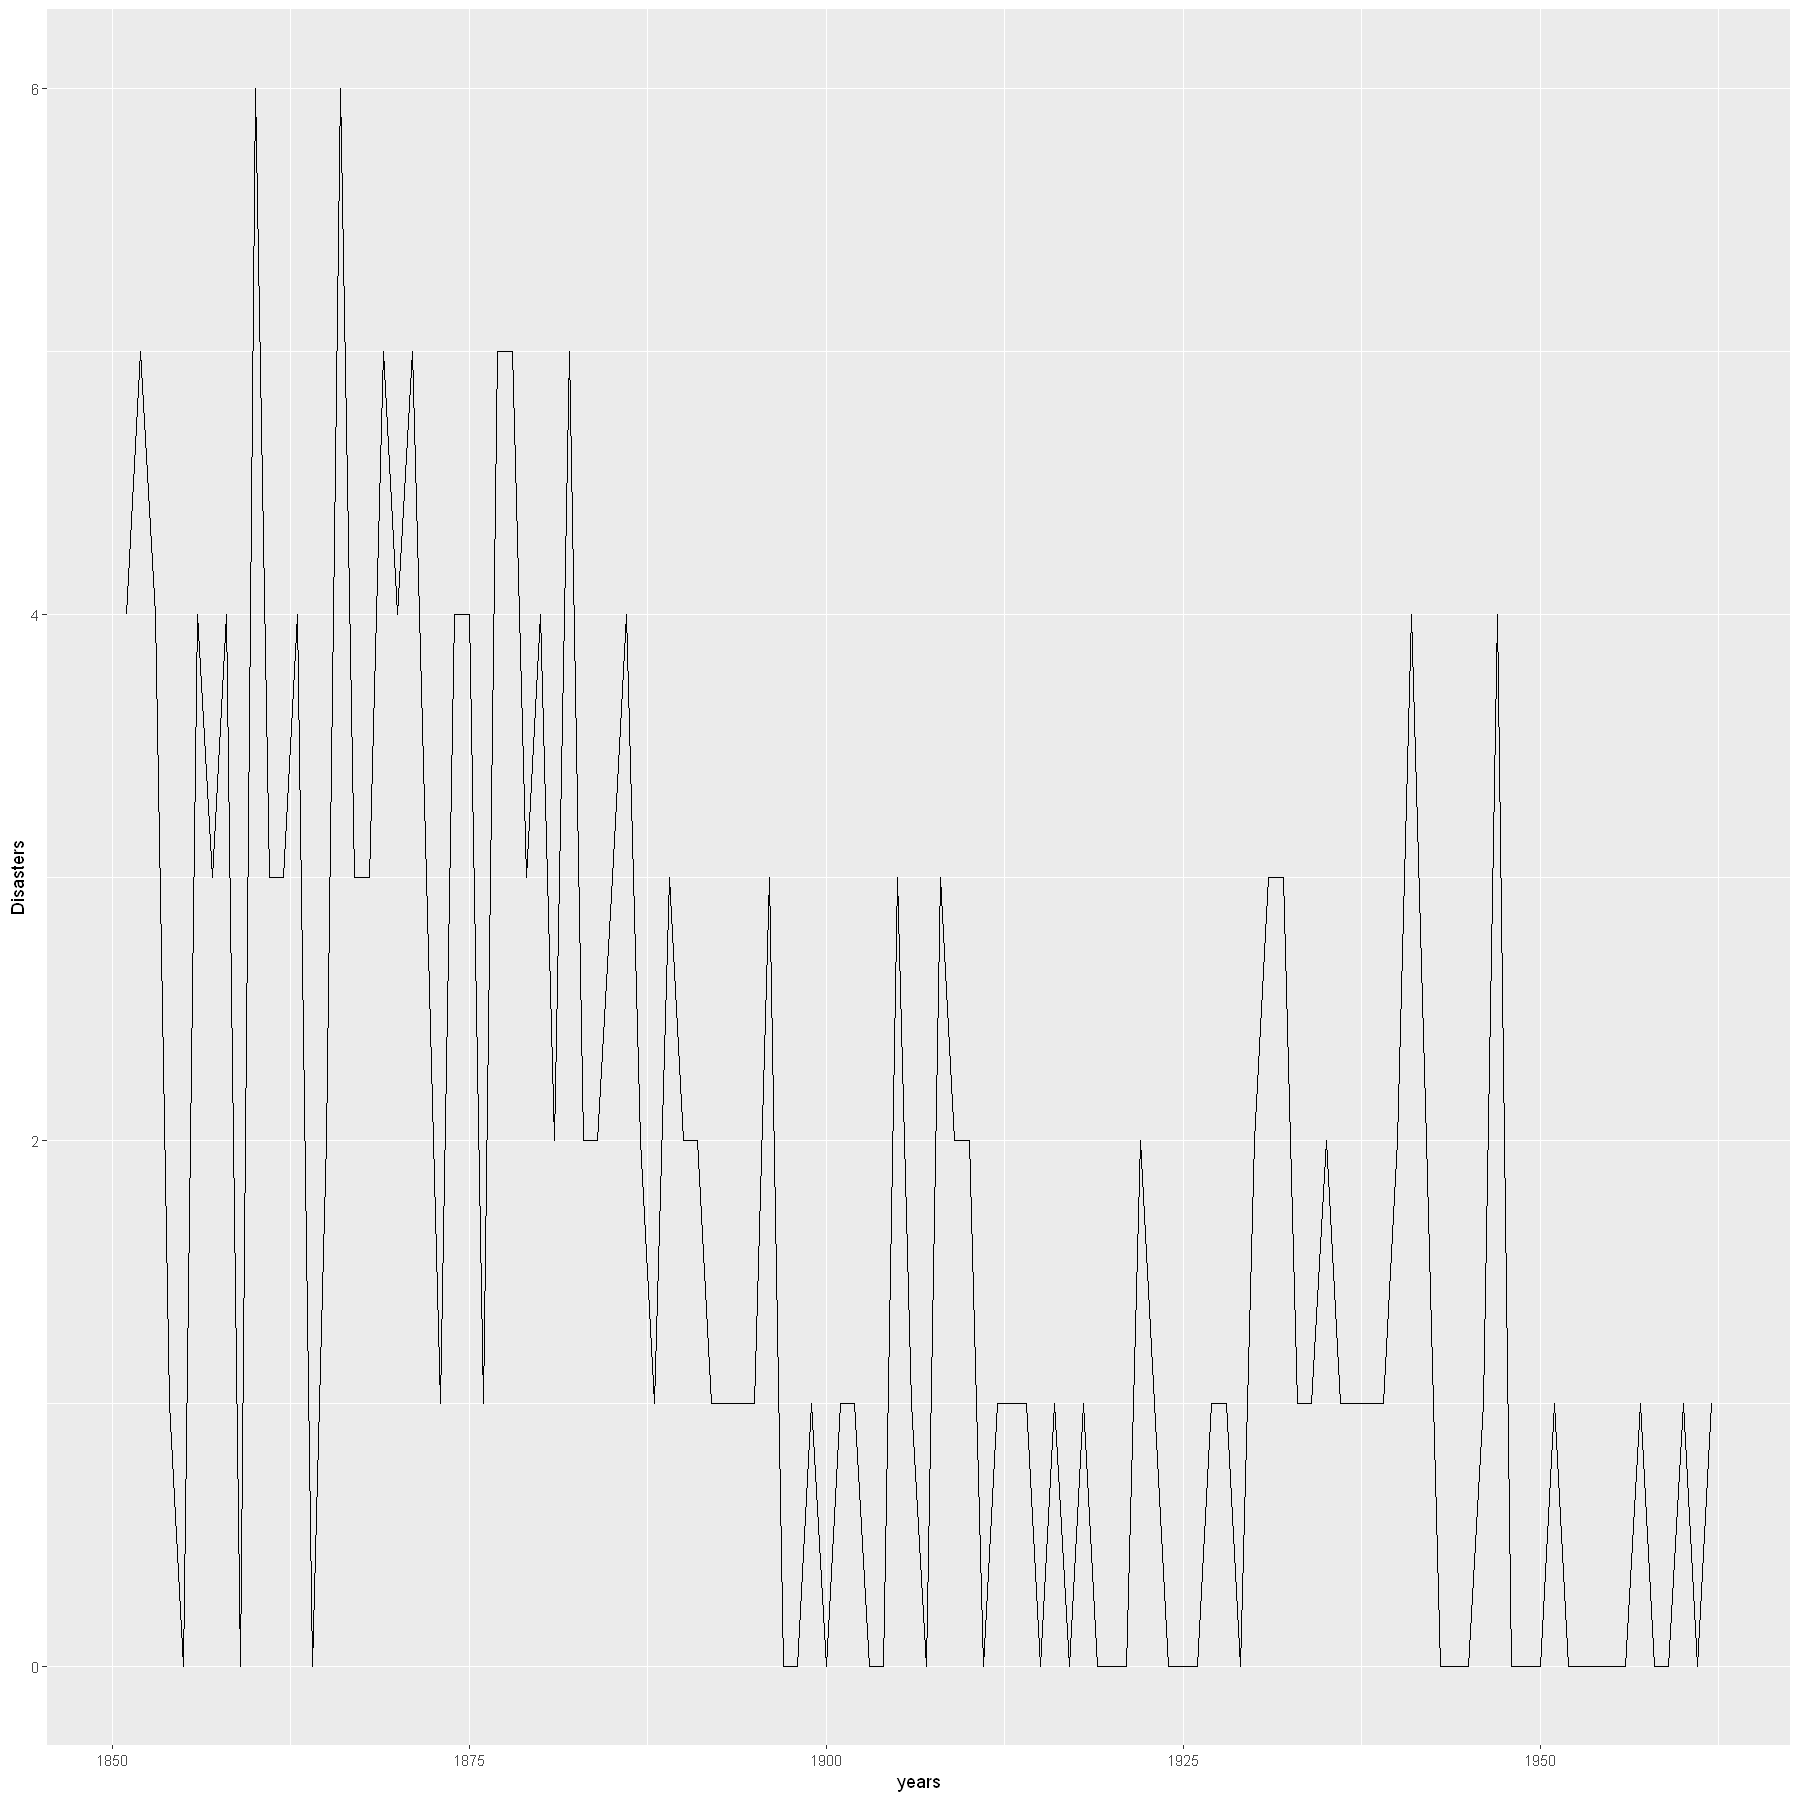

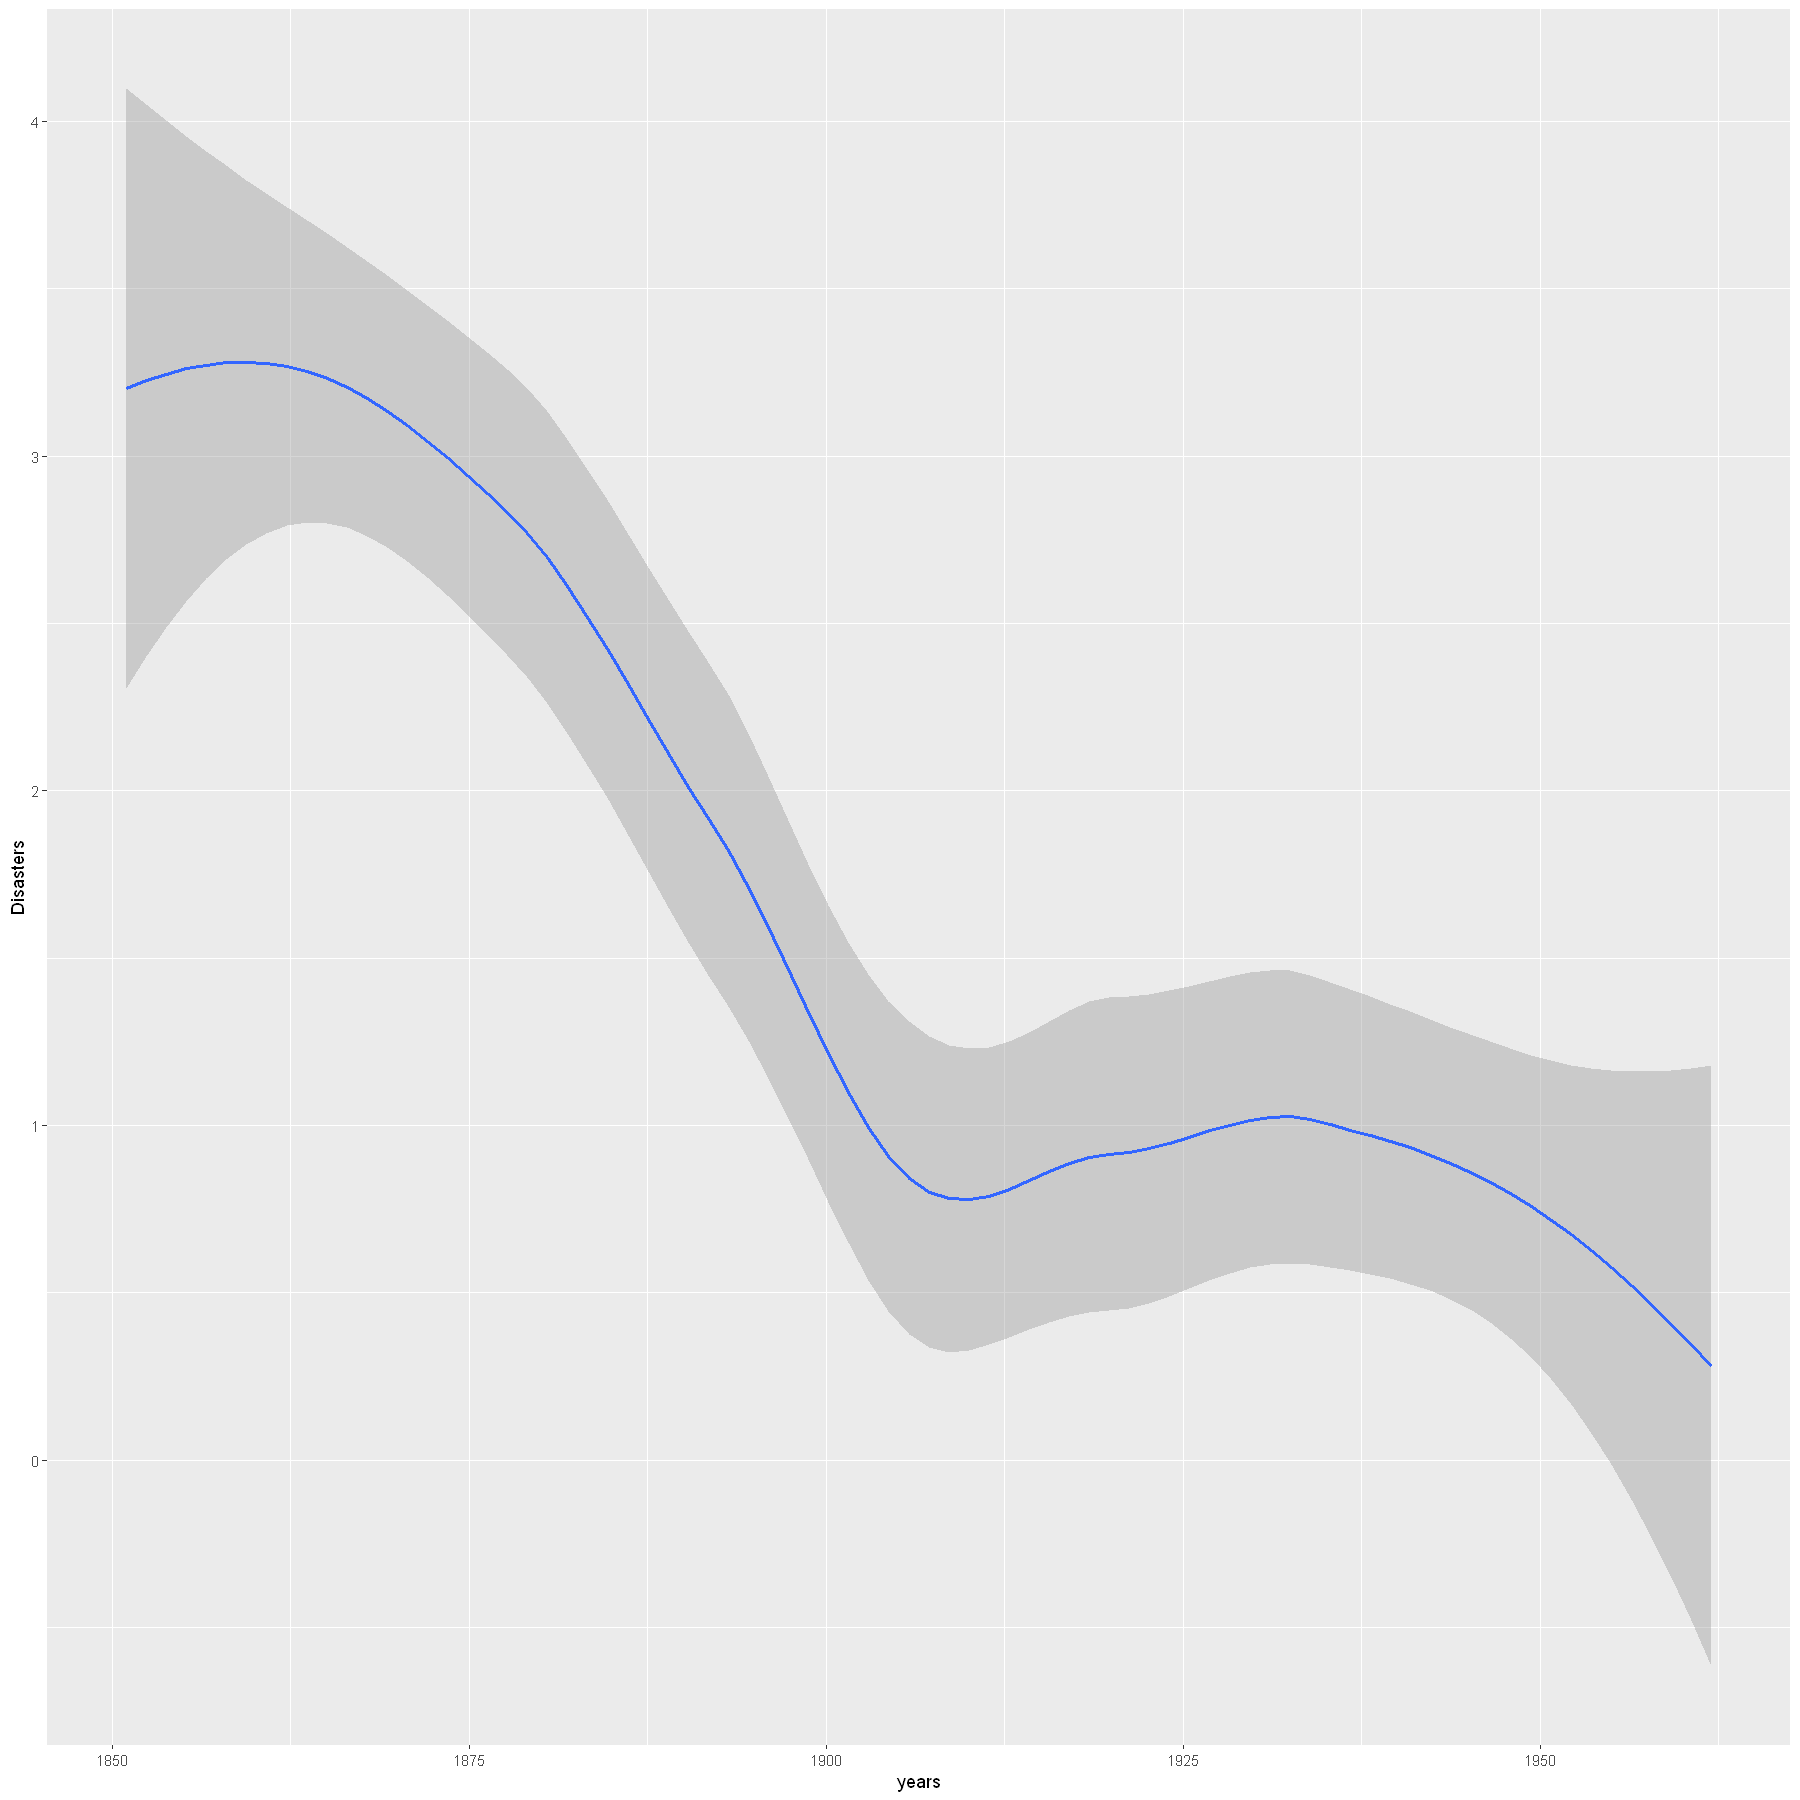

In [27]:
mining <- read.csv("Mining-Accidents-CPA.csv")
ggplot(mining,aes(years, Disasters))+geom_line()
ggplot(mining,aes(years, Disasters))+geom_smooth()

### (a) 사전분포를 가정하여 모수에 대한 사후분포 찾기 (JAGS)
* prior density : $h(a,b,c)$ 
* proposal density : $h(a,b,c | y_1, ... , y_n)$ 

In [28]:
t = mining$years ; y = mining$Disasters 
poisson_change<-"model{
  for(i in 1:length(t)) {
  y[i] ~ dpois(mu_t[i])
  mu_t[i]<-exp(a-b*ifelse((t[i]-c)>=0,1,0))
  }
  
  a ~ dunif(0,10)
  b ~ dunif(0,10)
  c ~ dunif(1851,1962)
}"

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 3
   Total graph size: 904

Initializing model

NOTE: Stopping adaptation




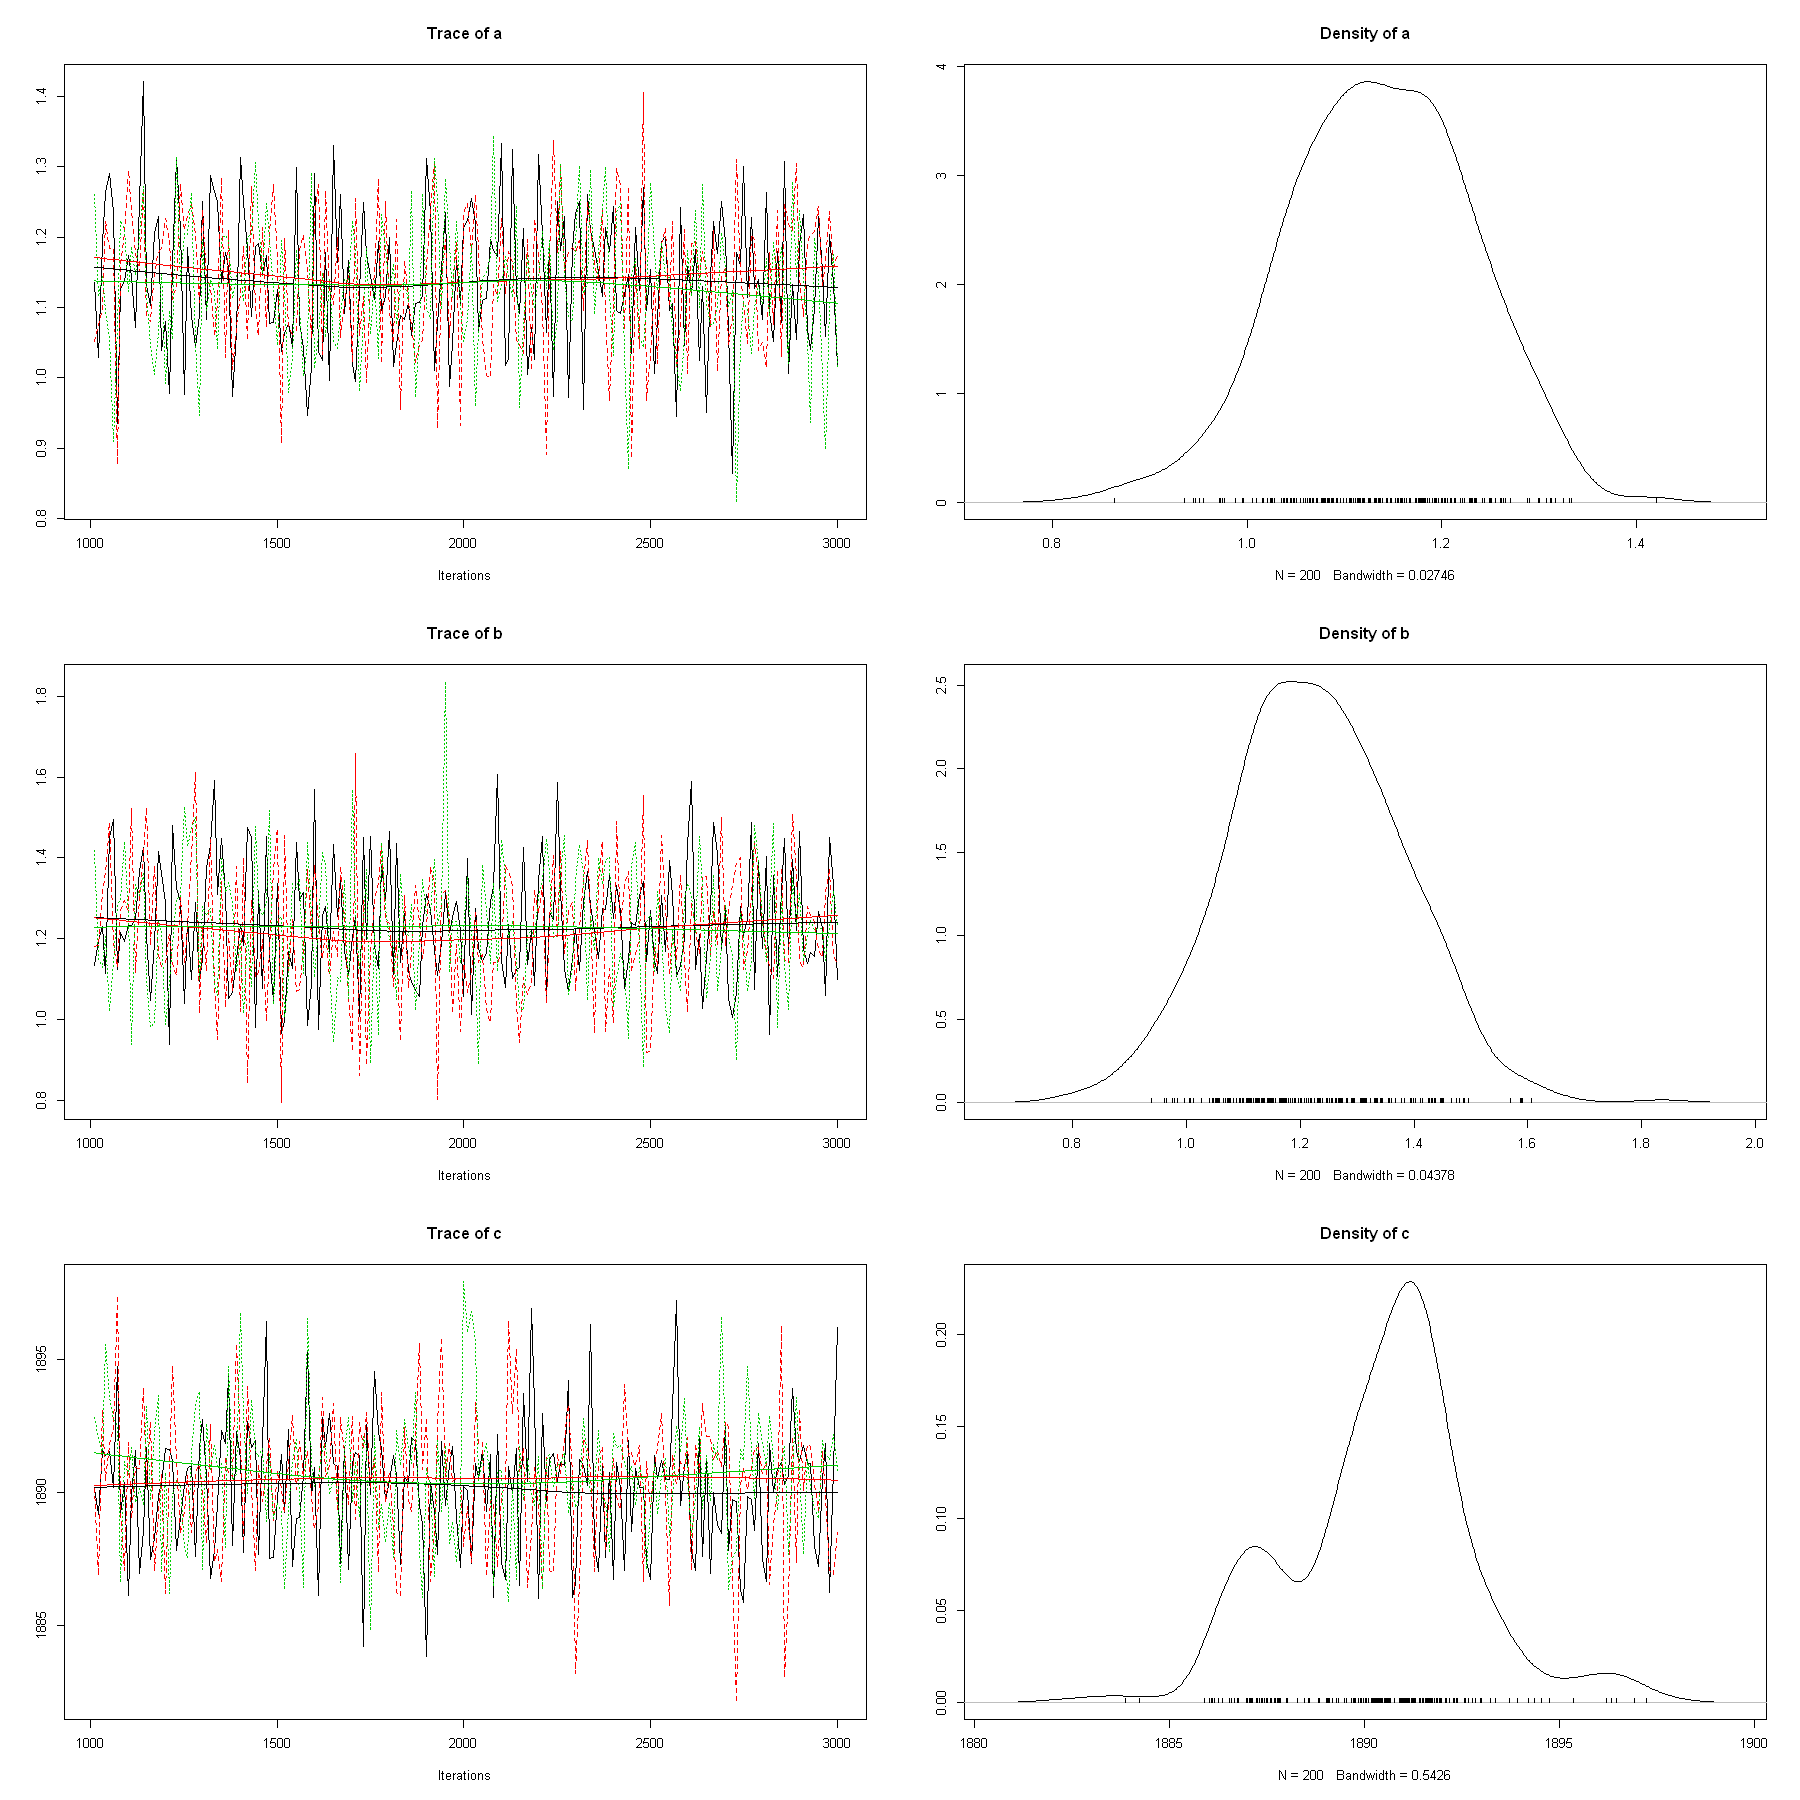

In [29]:
model<-jags.model(textConnection(poisson_change),data=list(t=t,y=y),n.chains=3,n.adapt=0)

# Burnin for 1000 samples 
update(model,1000) 

# Thin 
mcmc_samples<-coda.samples(model,variable.names=c("a","b","c"),n.iter=2000,thin=10)
plot(mcmc_samples)

### (b) Bayes 방법을 이용한 모수 추정 & Bayes CI 

In [30]:
mcmc_info <- summary(mcmc_samples) ; mcmc_info


Iterations = 1010:3000
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 200 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean      SD Naive SE Time-series SE
a    1.136 0.09311 0.003801       0.003665
b    1.227 0.14846 0.006061       0.005412
c 1890.420 2.32467 0.094904       0.099375

2. Quantiles for each variable:

       2.5%      25%      50%     75%    97.5%
a    0.9472    1.072    1.137    1.20    1.307
b    0.9434    1.128    1.223    1.33    1.500
c 1886.1523 1889.236 1890.710 1891.70 1895.673


In [31]:
ci.bayes <- data.frame(bayes = mcmc_info$statistics[,1], lower = mcmc_info$quantiles[,1], upper = mcmc_info$quantiles[,5])
ci.bayes

,bayes,lower,upper
,<dbl>,<dbl>,<dbl>
a,1.136178,0.9472149,1.306849
b,1.227115,0.9433512,1.500196
c,1890.420363,1886.1523224,1895.672989


### (c) MLE 방법을 이용한 모수 추정 

In [32]:
# MLE 
floglik<-function(theta) {
  mu<-exp(theta[1]-theta[2]*ifelse((mining$years-theta[3])>=0,1,0))
  L<-dpois(mining$Disasters,mu)
  return(sum(log(L)))
}

In [33]:
abc_bayes <- mcmc_info$statistics[,1]

abc_opt <- optim(par=abc_bayes,floglik,control=list(fnscale=-1),hessian=T)
abc_mle <- abc_opt$par
abc_opt 

,a,b,c
a,-190.99633,64.00034,0
b,64.00034,-64.00034,0
c,0.00000,0.00000,0


In [34]:
# Bootstrap 
n = length(y)
fbootsnp <- function(theta) {    
  a = theta[1] ; b = theta[2] ; c = theta[3]
  index <- sample(1:n, size = n, replace = T)
  rey = numeric(n) ; ret = numeric(n) ; li = numeric(n)
  for (i in 1:n) { 
    rey[i] <- y[index[i]] 
    ret[i] <- t[index[i]] 
    li[i] <- log(dpois(rey[i], exp(a - b*ifelse(ret[i] >= c, 1, 0)))) }
  l <- sum(li) 
  return(l) 
}

In [35]:
B = 1000 
mle.bnp = matrix(numeric(3*B), ncol = 3)

In [36]:
for (j in 1:B) {
  bnp_opt <- optim(par = abc_mle, fbootsnp, control = list(fnscale = -1))
  mle.bnp[j,] <- bnp_opt$par 
} 

In [37]:
ci.bnp <- data.frame(mean = c(mean(mle.bnp[,1]), mean(mle.bnp[,2]), mean(mle.bnp[,3])), lower = c(sort(mle.bnp[,1])[25], sort(mle.bnp[,2])[25], sort(mle.bnp[,3])[25]), upper = c(sort(mle.bnp[,])[975], sort(mle.bnp[,2])[975], sort(mle.bnp[,3])[975]))
ci.bnp

mean,lower,upper
<dbl>,<dbl>,<dbl>
1.073670,0.8162979,1.144045
1.297724,0.9273811,1.808557
1893.371631,1885.1005638,1912.832561


## Part 3. Bayes 방법을 이용한 하와이 상어 성장곡선 추정 

In [40]:
shark <- read.csv("Shark.csv")
y = shark$L2 ; x = shark$L1 ; t = shark$Days/365.25

### (a) 사전분포를 가정하여 모수에 대한 사후분포 찾기

In [41]:
shark_model<-"model{
  for(i in 1:length(t)) {
    y[i] ~ dnorm(mu[i],tau)
    mu[i] <- a-(a-x[i])*exp(-b*t[i])
  }

  a ~ dunif(0,400)
  b ~ dunif(0,10)
  sigma ~ dunif(0,50)
  tau<-1/sigma^2
}"

In [42]:
model_shark<-jags.model(textConnection(shark_model),data=list(t=t,x=x,y=y),n.chains=3,n.adapt=0)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 37
   Unobserved stochastic nodes: 3
   Total graph size: 302

Initializing model



NOTE: Stopping adaptation




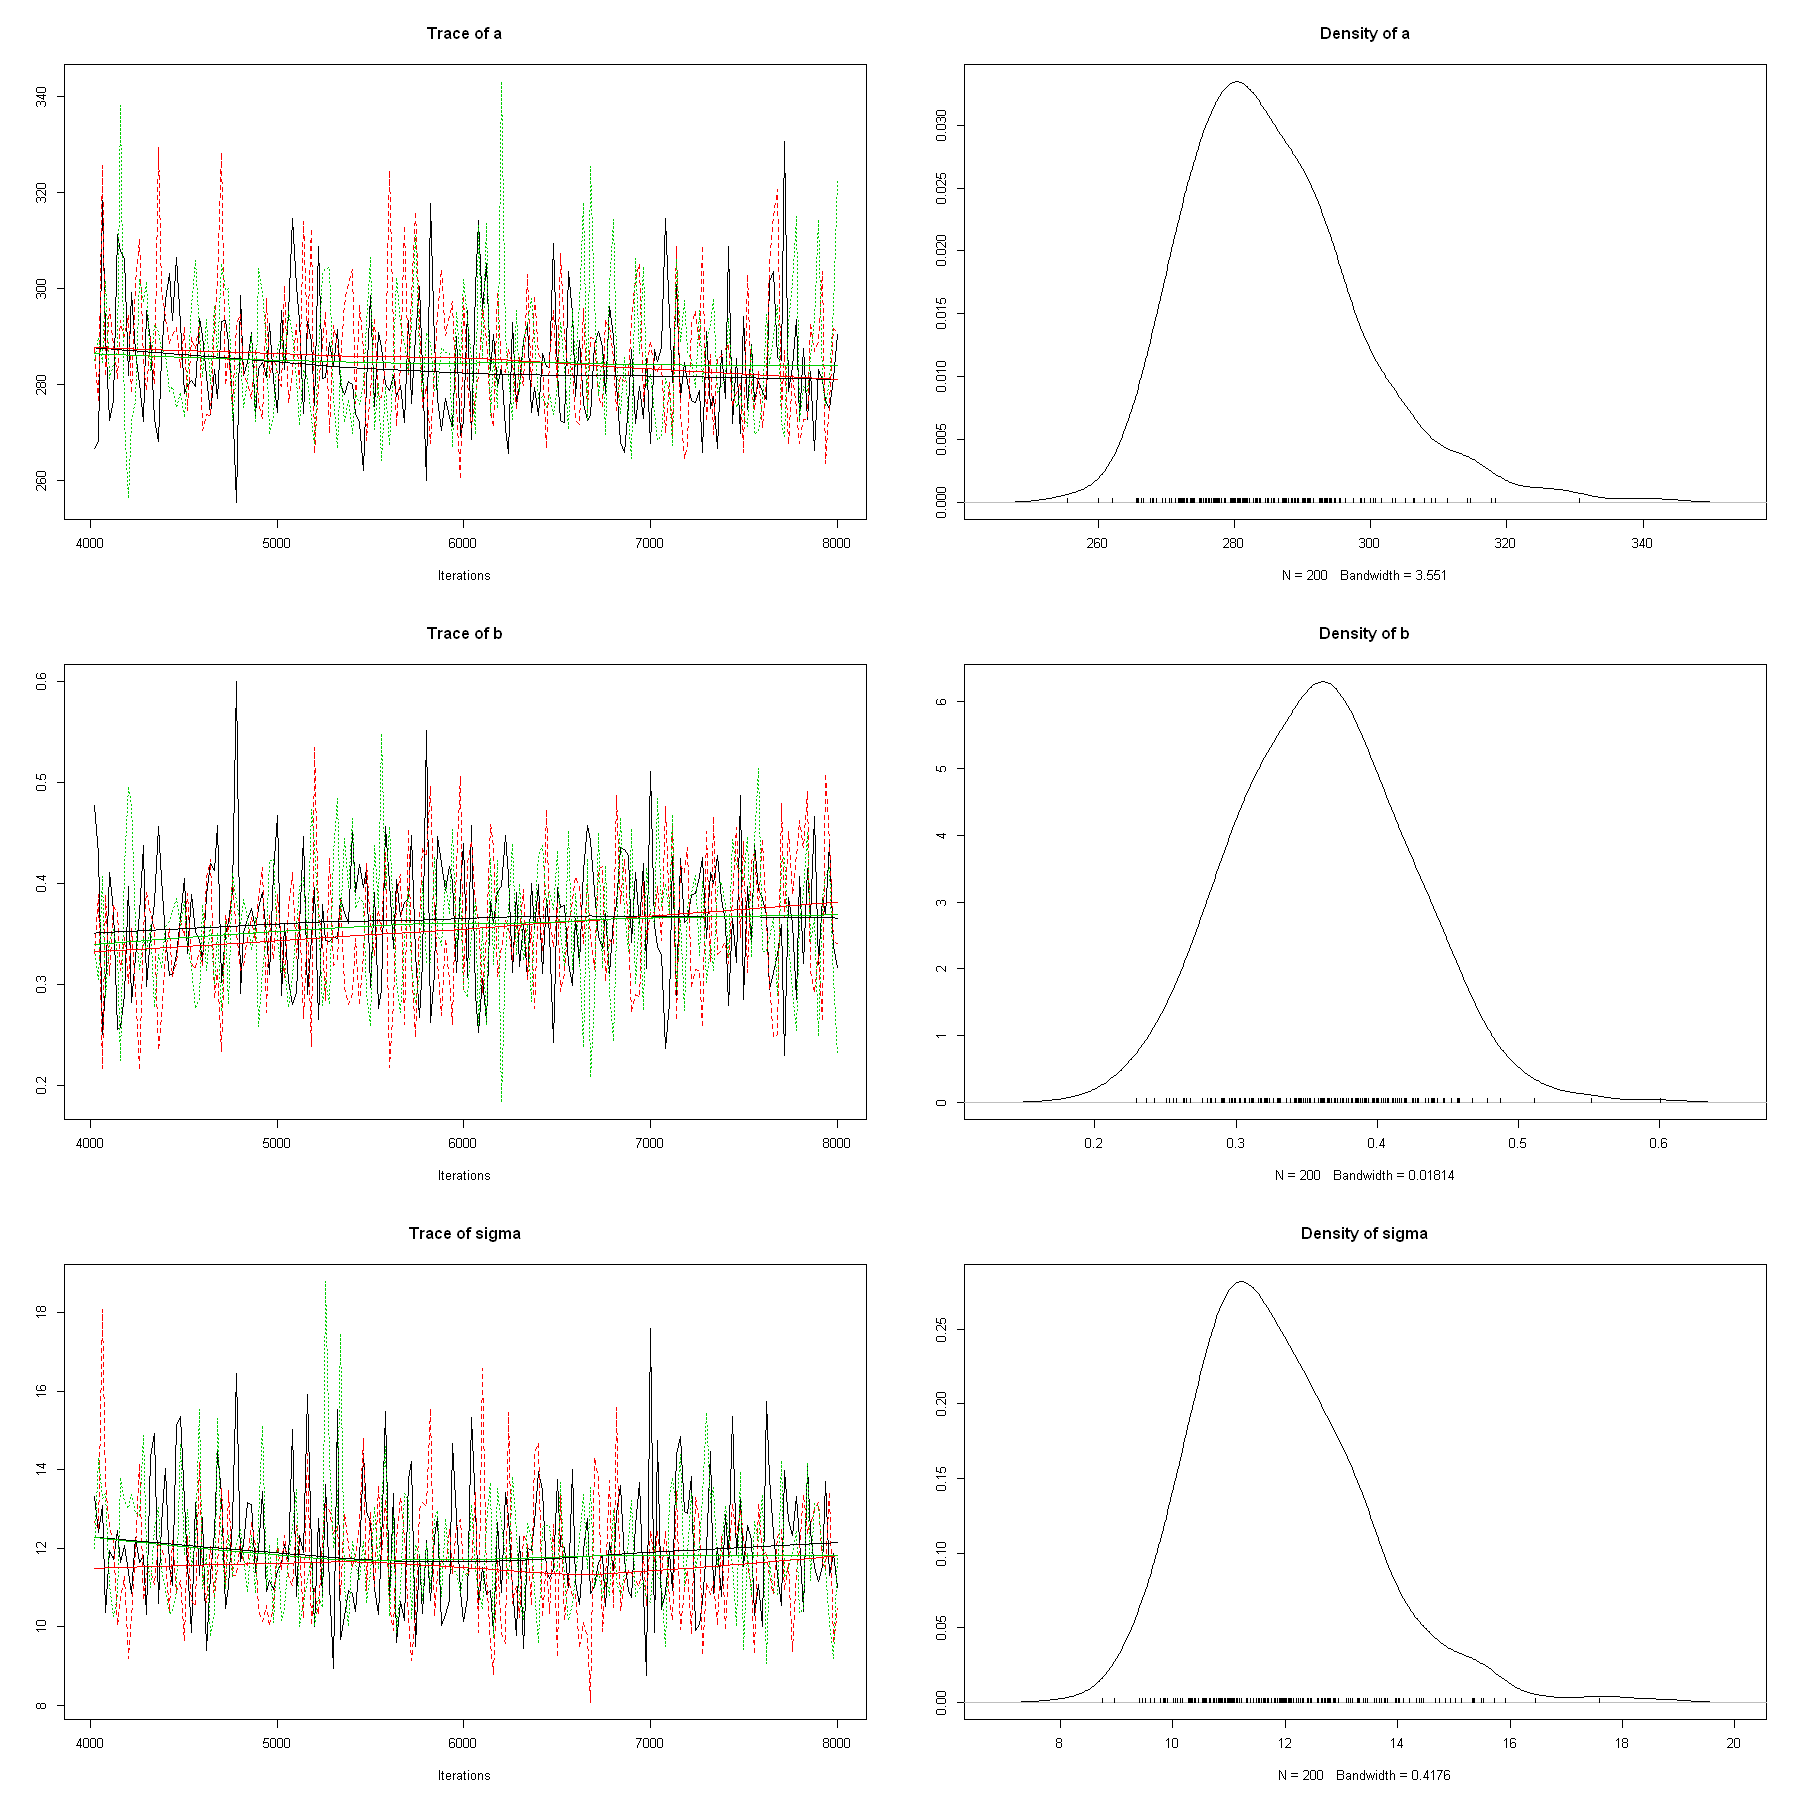

In [43]:
update(model_shark,4000) #Burnin for 4000 samples
mcmc_samples_shark<-coda.samples(model_shark,variable.names=c("a","b","sigma"),n.iter=4000,thin=20)
plot(mcmc_samples_shark)

### (b) Bayes 방법을 이용한 모수 추정 & Bayes CI

* $h(a,b,\sigma) = (L_\infty, k, \sigma)$
* prior density : $h(a,b,\sigma)$ 
* proposal density : $h(a,b,\sigma | Data)$ 

In [44]:
shark_info <- summary(mcmc_samples_shark) ; shark_info


Iterations = 4020:8000
Thinning interval = 20 
Number of chains = 3 
Sample size per chain = 200 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean       SD Naive SE Time-series SE
a     285.6201 12.80612 0.522807       0.504016
b       0.3604  0.06152 0.002512       0.002504
sigma  11.8789  1.50224 0.061329       0.055300

2. Quantiles for each variable:

          2.5%     25%      50%      75%    97.5%
a     266.5281 276.603 283.6979 292.7379 314.9876
b       0.2474   0.316   0.3598   0.4003   0.4796
sigma   9.4645  10.842  11.6584  12.7392  15.3603


In [45]:
ci.bayes <- data.frame(bayes = shark_info$statistics[,1], lower = shark_info$quantiles[,1], upper = shark_info$quantiles[,5])
ci.bayes

,bayes,lower,upper
,<dbl>,<dbl>,<dbl>
a,285.6200553,266.5280818,314.9876401
b,0.3604485,0.2473687,0.4795586
sigma,11.8789078,9.4644842,15.3603368


### (c) MLE 방법을 이용한 모수 추정 

In [46]:
floglik <- function(theta) {
  a = theta[1] ; b = theta[2] ; sigma = theta[3]
  l <- sum(log(dnorm(y, a-(a-x)*exp(-b*t), sigma)))
  return(l) 
}

In [47]:
shark_opt <- optim(par = ci.bayes$bayes, floglik, hessian = T, control = list(fnscale = -1))
shark_opt <- optim(par = shark_opt$par, floglik, hessian = T, control = list(fnscale = -1))

Warning message in dnorm(y, a - (a - x) * exp(-b * t), sigma):
"NaN이 생성되었습니다"
Warning message in dnorm(y, a - (a - x) * exp(-b * t), sigma):
"NaN이 생성되었습니다"


In [48]:
shark_mle <- shark_opt$par
J <- -shark_opt$hessian
V <- solve(J)
se <- sqrt(diag(V))

ci.mle <- data.frame(shark_mle, lower = c(shark_mle[1] - 1.96*se[1], shark_mle[2] - 1.96*se[2], shark_mle[3] - 1.96*se[3]), 
                     upper = c(shark_mle[1] + 1.96*se[1], shark_mle[2] + 1.96*se[2], shark_mle[3] + 1.96*se[3]), 
                     row.names = c("a", "b", "sigma")) 
ci.mle

,shark_mle,lower,upper
,<dbl>,<dbl>,<dbl>
a,283.3545869,262.6120005,304.0971733
b,0.3607828,0.2505647,0.4710009
sigma,11.0588520,8.5390956,13.5786084


* Bayes 방법과 MLE 방법을 이용하여 모수를 추정했을 때 약간의 차이가 있다. 
* Bayes 방법의 경우 데이터의 수가 적어지면 사전분포에 영향을 많이 받아 추정값이 달라진다는 것을 알 수 있다. 

### (d) Bayes & MLE 방법으로 추정된 성장곡선 

In [49]:
bayes <- ci.bayes$bayes
mle <- ci.mle$shark_mle

In [50]:
L0 = 51.5
t0b = log((bayes[1]-L0)/bayes[1])/bayes[2]
t0m = log((mle[1]-L0)/mle[1])/mle[2]
as.numeric(c(t0b, t0m))

[1] -0.5516140 -0.5559818

In [51]:
gtb <- data.frame(tb = seq(t0b, 30, length = 100), tm = seq(t0m, 30, length = 100)) %>% mutate(ltb = bayes[1]*(1-exp(-bayes[2]*(tb-t0b))), ltm = mle[1]*(1-exp(-mle[2]*(tm-t0m))))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



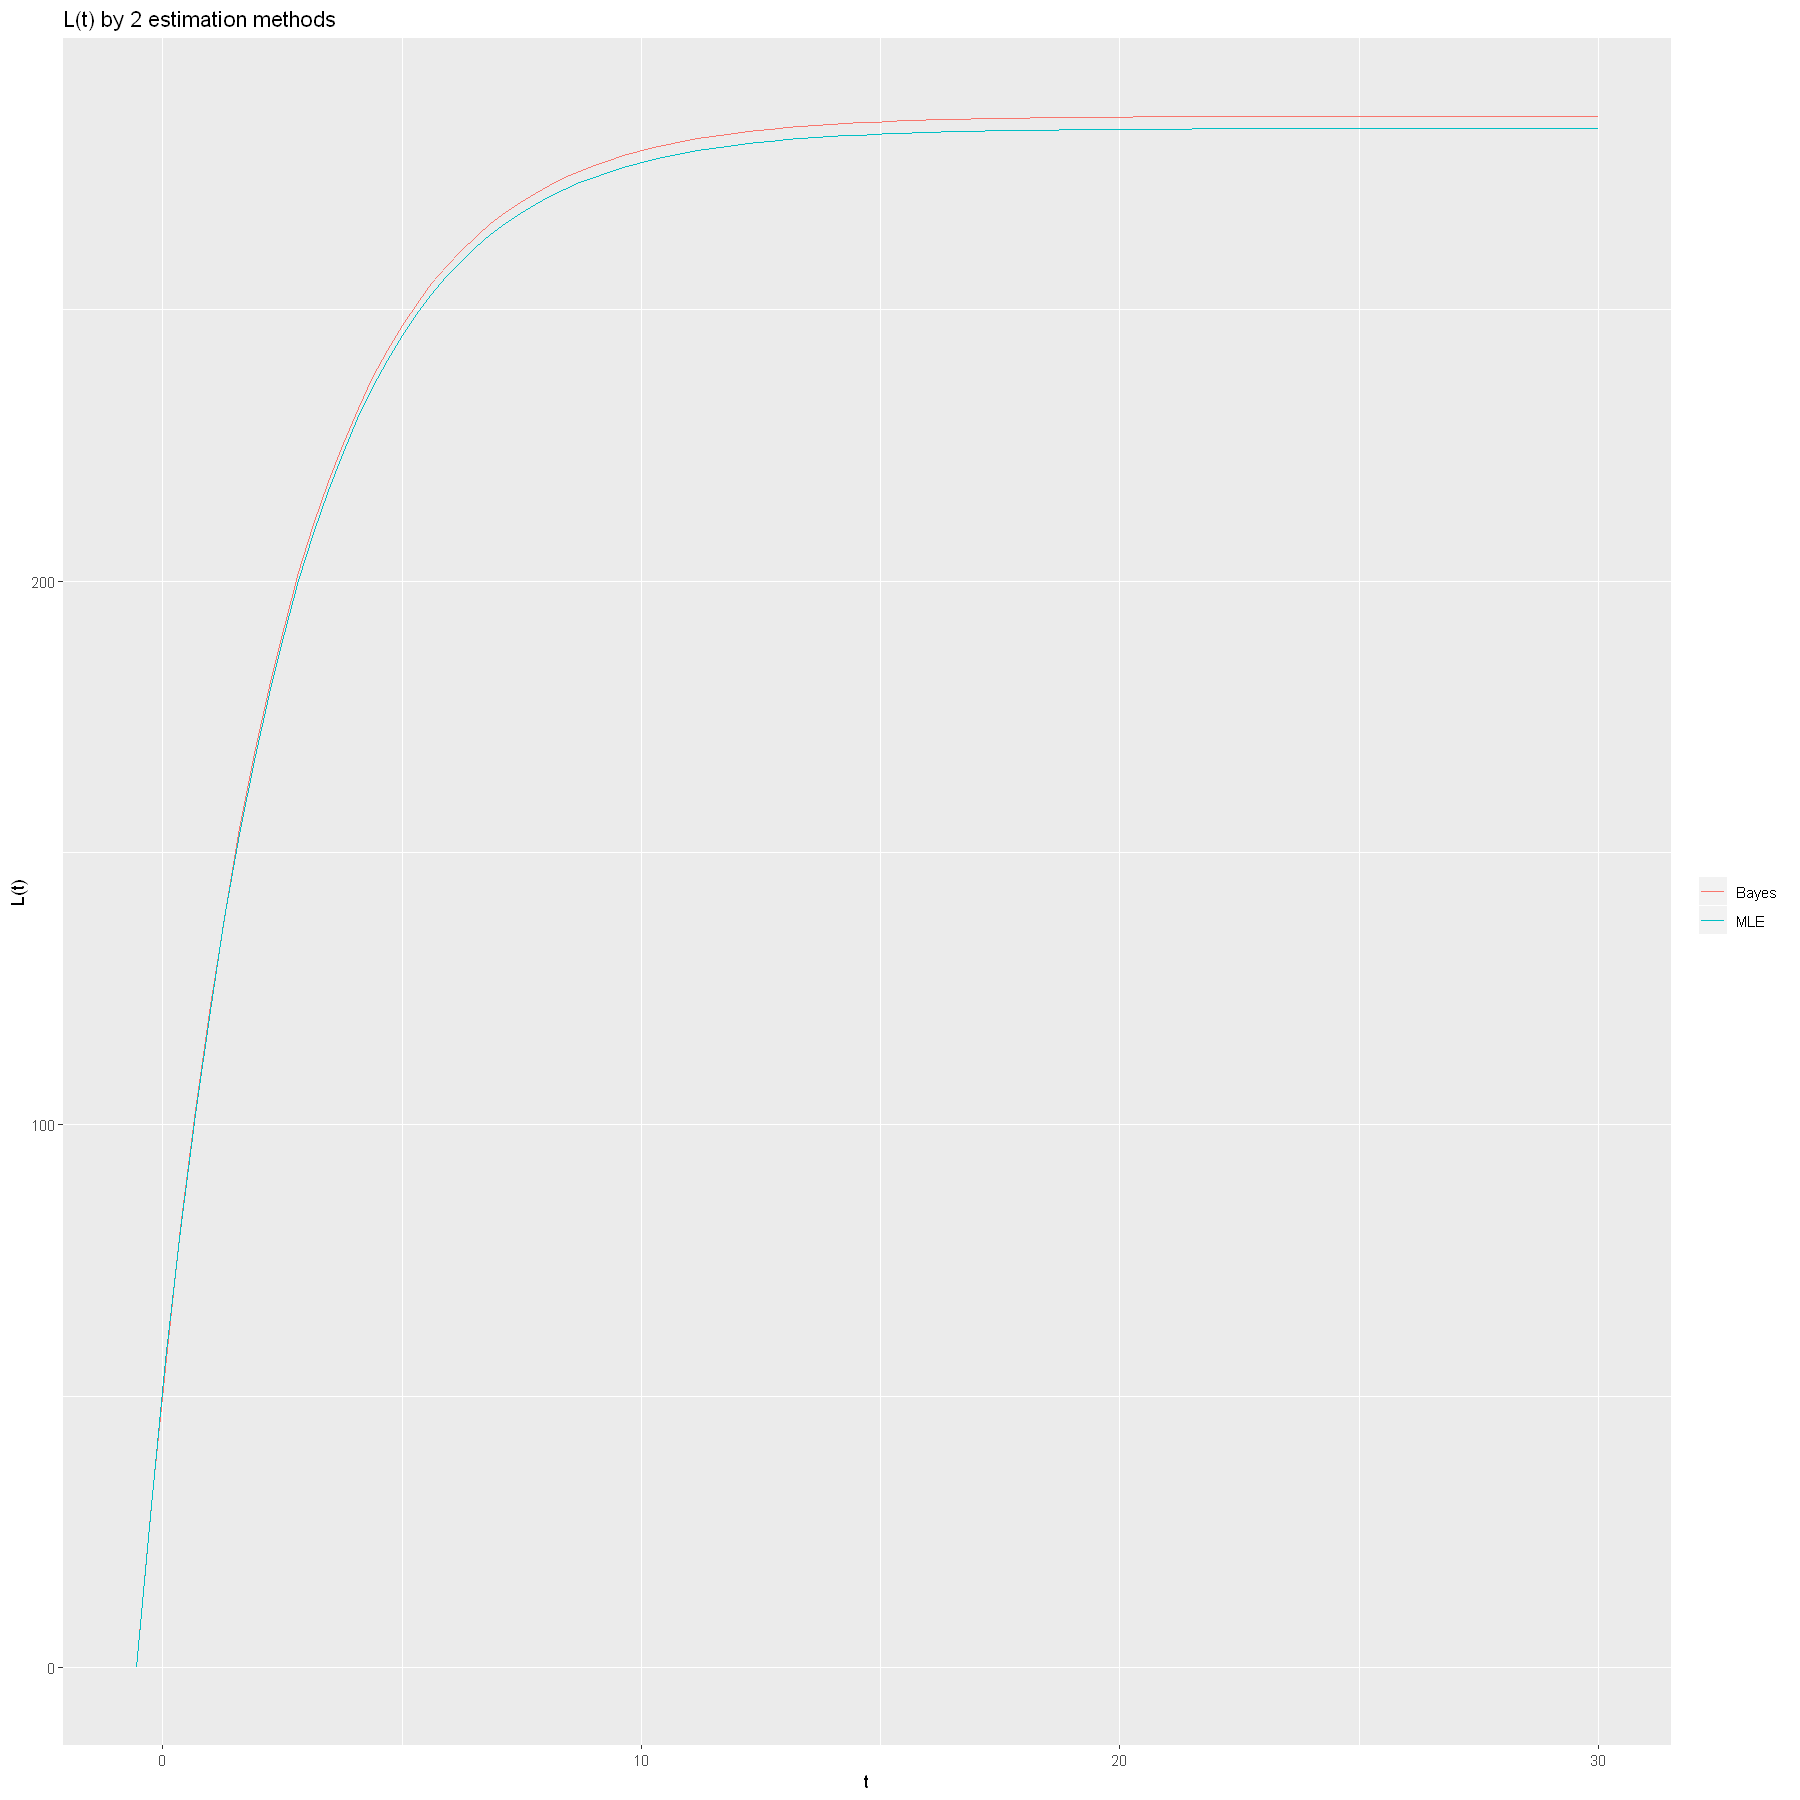

In [52]:
cols = c("Bayes" = "red", "MLE" = "blue")
ggrowth <- ggplot(data = gtb) + scale_colour_manual(values = cols, breaks = c("Bayes", "MLE")) + geom_line(aes(tb, ltb, colour = "Bayes")) + geom_line(aes(tm, ltm, colour = "MLE")) + labs(x = "t", y = "L(t)", title = "L(t) by 2 estimation methods") + scale_colour_discrete(name = "")
ggrowth

* Bayes 방법을 통해 추정한 성장곡선과 MLE 방법을 통해 추정한 성장곡선은 거의 일치한다

## + Bayes vs MLE 

### MLE 
* (+) 분포에 대한 별다른 가정 없이 모수를 추정할 수 있다.
* (-) 모수의 개수가 많거나 데이터의 개수가 적은 경우에는 베이즈 방법으로 추정할 때보다 정확하지 않다.         
 


### Bayes
* (+) 분포가 아무리 복잡하더라도, 분포에 관계없이 모수를 추정할 수 있다. 
* (+) 모수의 개수가 많거나 데이터의 수가 적어도(=MLE의 단점) 베이즈 방법을 사용하는데 문제가 없다.
* (-) 모수에 대한 사전분포를 가정할 때 사전지식이 필요할 수도 있다. 
* (-) 데이터의 수가 적을 때 사전분포를 어떤 분포로 가정하냐에 따라 추정값에 영향을 많이 미친다.